In [35]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 

connection = sqlite3.connect('../data/Köksglädje.db')

table_names = ['customers', 'products', 'stores', 'transactiondetails', 'transactions']

df = {}
for table in table_names:
    df[table] = pd.read_sql_query(f"SELECT * FROM {table}", connection)

df_customers = df['customers'] 
df_products = df['products']
df_stores = df['stores']
df_td = df['transactiondetails']
df_transactions = df['transactions']

## Display DataFrame information

In [42]:
print ('------Customers information------')
df_customers.info()

print ('-----products information-----')
df_products.info()

print ('-----stores information-----')
df_stores.info()

print('-----transactiondetalis information-----')
df_td.info()

print ('-----transaction information-----')
df_transactions.info()


------Customers information------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         100 non-null    int64  
 1   JoinDate           100 non-null    object 
 2   ActiveMember       97 non-null     float64
 3   ApprovedToContact  97 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ KB
-----products information-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ProductID     40 non-null     int64  
 1   ProductName   40 non-null     object 
 2   Description   40 non-null     object 
 3   CategoryName  40 non-null     object 
 4   Price         40 non-null     float64
 5   CostPrice     40 non-null     float64
dtypes: float64(2), int64(1), object

## Visualize Price vs CostPrice

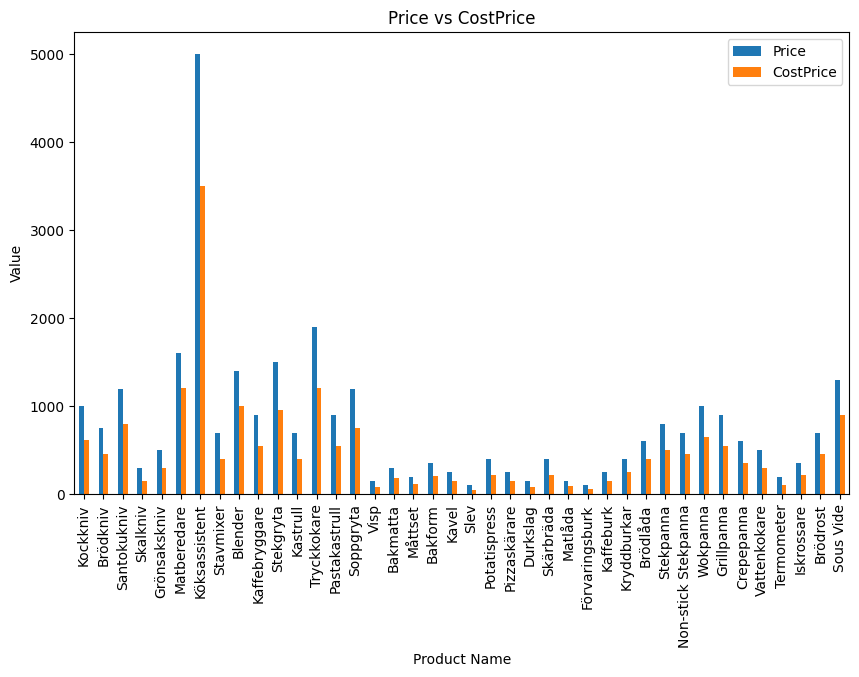

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df_products[['Price', 'CostPrice']].plot(kind='bar', ax=ax)

plt.xticks(ticks=range(len(df_products)), labels=df_products['ProductName'], rotation=90)

plt.title('Price vs CostPrice')
plt.xlabel('Product Name')
plt.ylabel('Value')
plt.show()

In [40]:
df_td_transactions = df_td.merge(
    df_transactions[['TransactionID', 'StoreID']],  
    on='TransactionID',  
    how='left' )  

df_td_transactions = df_td_transactions.merge(
    df_stores[['StoreID', 'StoreName']], 
    on='StoreID', 
    how='left')

print(df_td_transactions)

      TransactionDetailID  TransactionID  ProductID  Quantity  \
0                       1              1         14         1   
1                       2              1         23         3   
2                       3              1         37         1   
3                       4              1          8         1   
4                       5              2          2         1   
...                   ...            ...        ...       ...   
2972                 2973            997         16         1   
2973                 2974            998         22         1   
2974                 2975            999         36         1   
2975                 2976            999         17         1   
2976                 2977           1000         10         1   

      PriceAtPurchase  TotalPrice  StoreID                    StoreName  
0               899.0       899.0        8           Köksproffset Malmö  
1               249.0       747.0        8           Köksproffset Malmö

## Analyze sales per store

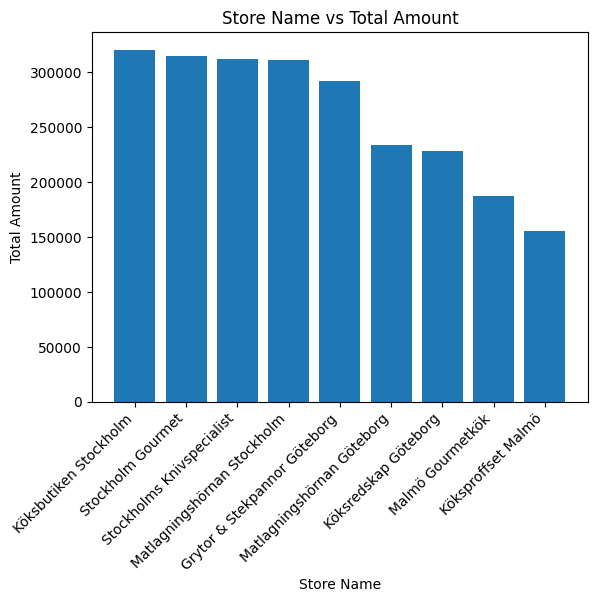

In [10]:

df_td_transactions['TotalAmount'] = df_td_transactions['Quantity'] * df_products.set_index('ProductID').loc[df_td_transactions['ProductID'], 'Price'].values

store_sales = df_td_transactions.groupby(['StoreID', 'StoreName'])['TotalAmount'].sum().sort_values(ascending=False).reset_index()

plt.bar(store_sales['StoreName'], store_sales['TotalAmount'])
plt.title('Store Name vs Total Amount')
plt.xlabel('Store Name')
plt.ylabel('Total Amount')
plt.xticks(rotation=45, ha='right') 
plt.show()

## Identify least sold products

In [41]:
least_sold = df_td_transactions.groupby('ProductID')['Quantity'].sum().reset_index()
least_sold = least_sold.merge(df_products[['ProductID', 'ProductName']], on='ProductID')
least_sold = least_sold.sort_values(by='Quantity').head(20)  # De 10 minst sålda
print(least_sold)

    ProductID  Quantity          ProductName
13         14        50        Pastakastrull
10         11        65            Stekgryta
11         12        67             Kastrull
35         36        67         Vattenkokare
2           3        68          Santokukniv
24         25        68            Skärbräda
0           1        68             Kockkniv
14         15        69            Soppgryta
32         33        69             Wokpanna
1           2        70             Brödkniv
21         22        71         Potatispress
8           9        71              Blender
39         40        71            Sous Vide
22         23        72         Pizzaskärare
12         13        72          Tryckkokare
31         32        72  Non-stick Stekpanna
29         30        73             Brödlåda
38         39        76             Brödrost
4           5        76         Grönsakskniv
27         28        78            Kaffeburk


## Sales over time

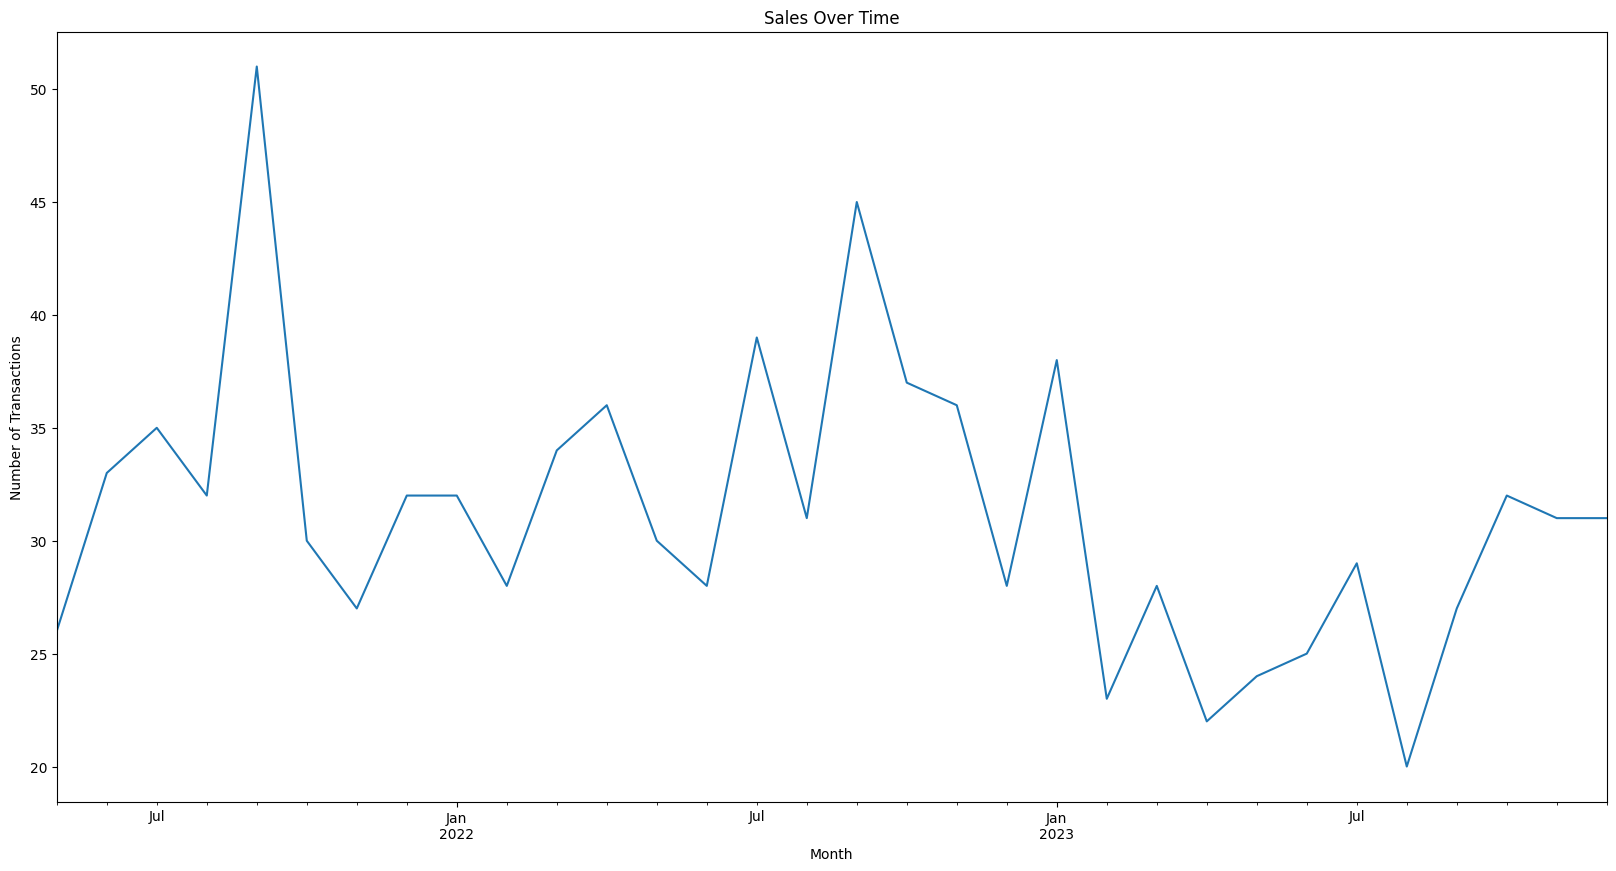

In [16]:
sales_over_time = df_transactions.groupby(df_transactions['TransactionDate'].dt.to_period('M')).size()
sales_over_time.plot(kind='line', figsize=(20, 10))
plt.title('Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()


## Sales by weekday

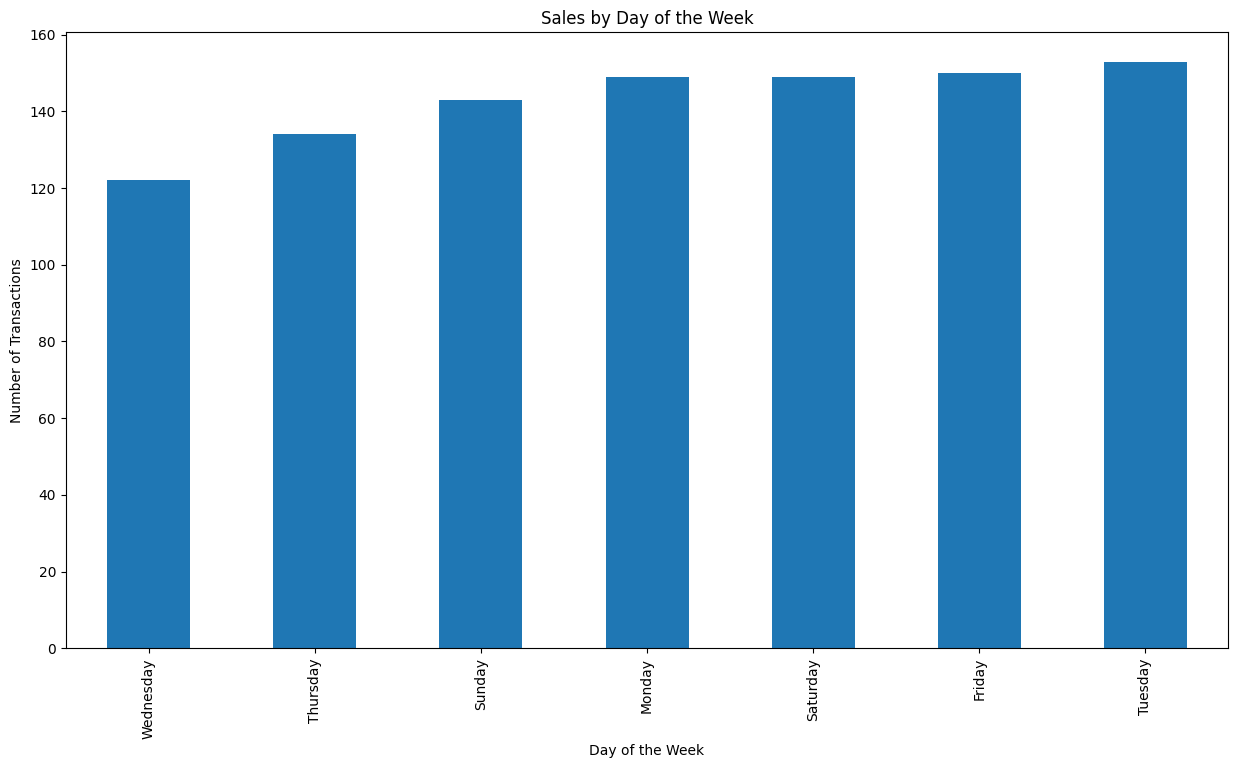

In [18]:
weekday_sales = df_transactions.groupby(df_transactions['TransactionDate'].dt.day_name())['TransactionID'].count()
weekday_sales = weekday_sales.sort_values()
weekday_sales.plot(kind='bar', figsize=(15, 8))
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.show()


## Calculate Profit Margin

In [95]:
df_products['ProfitMargin'] = df_products['Price'] - df_products['CostPrice']
profitable_products = df_products.sort_values(by='ProfitMargin', ascending=False).head(10)
print(profitable_products)


    ProductID    ProductName                                  Description  \
6           7  Köksassistent  Kraftfull köksassistent med 4,5 liters skål   
12         13    Tryckkokare                          Tryckkokare 6 liter   
10         11      Stekgryta                       Gjutjärnsgryta 4 liter   
14         15      Soppgryta                            Soppgryta 5 liter   
8           9        Blender             Högpresterande blender 1,5 liter   
2           3    Santokukniv                    Japansk Santokukniv 17 cm   
5           6    Matberedare           Matberedare med 2 liters kapacitet   
39         40      Sous Vide             Sous Vide-cirkulator med display   
0           1       Kockkniv                               Kockkniv 18 cm   
13         14  Pastakastrull                     Pastakastrull med insats   

         CategoryName   Price  CostPrice  profit  ProfitMargin  
6        Köksmaskiner  4999.0     3500.0  1499.0        1499.0  
12  Grytor/Kastruller 